In [1]:
import cv2
import matplotlib.pyplot as plt
import numpy as np
import tqdm

%matplotlib inline

In [2]:
import matplotlib as mpl

In [3]:
import vehicleDetection

/home/tsbertalan/.virtualenvs/carnd/lib/python3.5/site-packages/sklearn/cross_validation.py:41: DeprecationWarning: This module was deprecated in version 0.18 in favor of the model_selection module into which all the refactored classes and functions are moved. Also note that the interface of the new CV iterators are different from that of this module. This module will be removed in 0.20.
  "This module will be removed in 0.20.", DeprecationWarning)


# Load and look at the training data.

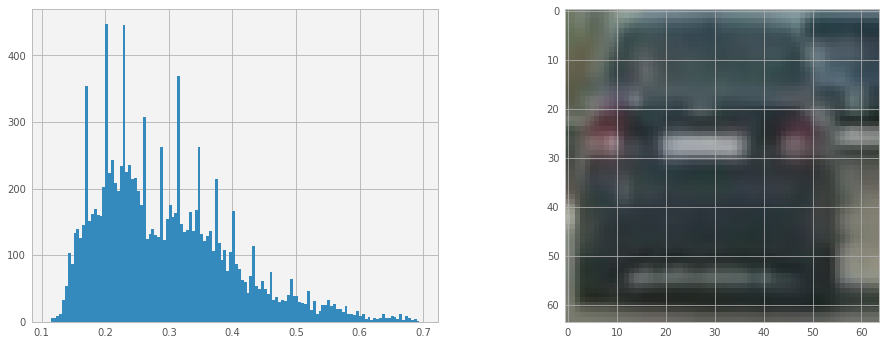

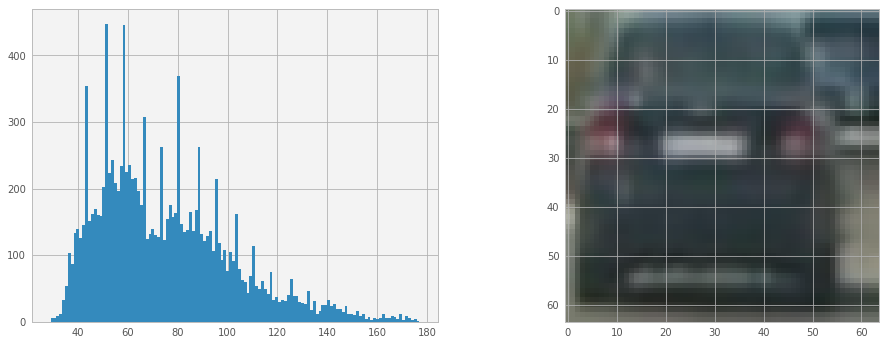

In [4]:
import matplotlib.image as mpimage

filePath = 'data/vehicles/vehicles/GTI_MiddleClose/image0000.png'

data = mpimage.imread(filePath)
# scaled = (data*255).astype('uint8')
scaled = vehicleDetection.data.readImage(filePath)

def shw(img):
    fig, axes = plt.subplots(figsize=(16,6), ncols=2)
    axes[0].hist(img.ravel(), bins=128)
    axes[1].imshow(img)

shw(data)

shw(scaled)

In [5]:
images, classes = vehicleDetection.data.getData()

HBox(children=(IntProgress(value=0, max=6726), HTML(value='')))

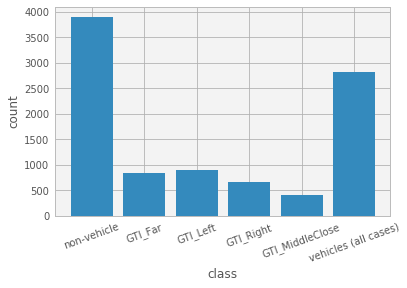

In [6]:
fig, ax = plt.subplots()
classLabels = [0, 1, 2, 3, 4]
x = []
y = []
x.extend(classLabels)
y.extend([classes.count(label) for label in classLabels])
x.append(5)
y.append(np.array(classes).astype(bool).astype(int).sum())
ax.bar(x, y)
ax.set_xticks(range(6))
classLabelNames = ['non-vehicle']
classLabelNames.extend(vehicleDetection.data.subKeys['vehicles'])
classLabelNames.append('vehicles (all cases)')
ax.set_xticklabels(classLabelNames, rotation=20);
ax.set_ylabel('count')
ax.set_xlabel('class');

In [7]:
indices = np.arange(len(images))
np.random.shuffle(indices)
n = 1024
imageWindows = [images[i] for i in indices[:n]]
windowClasses = [classes[i] for i in indices[:n]]

In [8]:
best_params_ = {'gamma': 6.5793322465756827e-05, 'kernel': 'rbf', 'C': 15.199110829529332}
# best_params_ = {'gamma': 10**(-4), 'kernel': 'rbf', 'C': 2}
# best_params_ = {'kernel': 'linear', 'C': 1.0}

# Maybe do a hyperparameter search.

Show the hyperparameter search score results.

In [9]:
hyperparameterSearch = False

In [10]:
%%time

if hyperparameterSearch:
    
    # Do a hyperparameter search.
    detector = vehicleDetection.detector.Detector(
        clfParameters=dict(
            C=np.logspace(-3, 1.6, 12),
            gamma=np.logspace(-8, -2, 12),
        )
    )
    detector.fit(
        imageWindows, 
        windowClasses,
    )
    
    
    # Extract the best parameters.
    best_params_ = detector.clf.best_params_

    # Extract the grid search cases for plotting.
    scores = [sc.mean_validation_score for sc in detector.clf.grid_scores_]
    Cs = [sc.parameters['C'] for sc in detector.clf.grid_scores_]
    gammas = [sc.parameters['gamma'] for sc in detector.clf.grid_scores_]

CPU times: user 0 ns, sys: 0 ns, total: 0 ns
Wall time: 4.53 µs


In [11]:
if hyperparameterSearch:
    # Plot the scores from the hyperparameter search.
    Cflat = list(sorted(set(Cs)))
    gammaflat = list(sorted(set(gammas)))
    grid = np.ones((len(Cflat), len(gammaflat))) * np.mean(scores)
    
    for score, C, gamma in zip(scores, Cs, gammas):
        iC = Cflat.index(C)
        ig = gammaflat.index(gamma)
        grid[iC, ig] = score

    fig, ax = plt.subplots(figsize=(16,9))
    im = ax.imshow(grid, origin='lower', interpolation='spline16', cmap='viridis')
    fig.colorbar(im, label='score')

    # sc = ax.scatter(np.log10(gammas), np.log10(Cs), c=scores)
    # fig.colorbar(sc, label='score')

    C = best_params_['C']
    gamma = best_params_['gamma']
    ax.scatter(gammaflat.index(gamma), Cflat.index(C), label='best', color='grey', s=256)

    ax.set_xticks(range(len(gammaflat)))
    ax.set_yticks(range(len(Cflat)))
    logformat = lambda n: '$10^{%.2g}$' % np.log10(n)
    lfm = lambda l: [logformat(n) for n in l]
    ax.set_xticklabels(lfm(gammaflat))
    ax.set_yticklabels(lfm(Cflat))
    ax.set_title('hyperparameter search')
    ax.set_xlabel('$\gamma$')
    ax.set_ylabel('$C$');
    ax.legend();
    fig.savefig('doc/hyperparameterSearch.png')

# Train the classifier on the full dataset with the best classifier parameters.

In [12]:
# Try a decision tree.

# import sklearn.tree
# CLF = sklearn.tree.DecisionTreeClassifier
# best_params_ = dict(min_samples_split=2, min_samples_leaf=1, criterion='gini')
# detector = vehicleDetection.detector.Detector(clfParameters=best_params_, CLF=CLF)

Look at the generated features.

Got scalar parameter (C). Assuming no CV requested.


/home/tsbertalan/.virtualenvs/carnd/lib/python3.5/site-packages/skimage/feature/_hog.py:119: skimage_deprecation: Default value of `block_norm`==`L1` is deprecated and will be changed to `L2-Hys` in v0.15
  'be changed to `L2-Hys` in v0.15', skimage_deprecation)


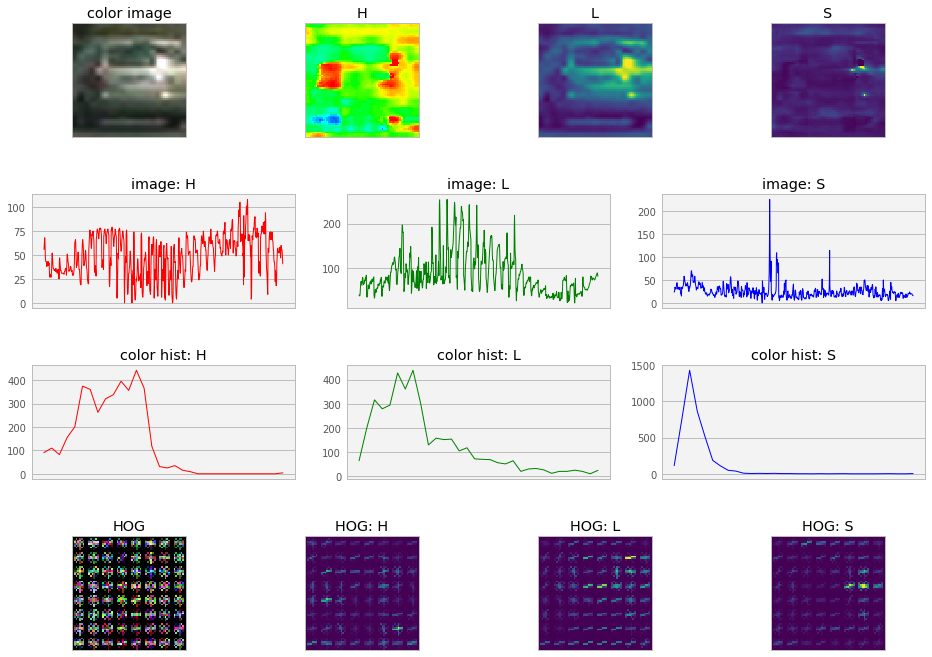

In [13]:
from importlib import reload
reload(vehicleDetection.features)

detector = vehicleDetection.detector.Detector(clfParameters=best_params_)

i = classes.index(True)
image = images[i]
fig, axes = detector.featurize.visualize(image);
fig.savefig('doc/featuresVisualized.png')

In [14]:
# i = classes.index(True)
# fig, axes = plt.subplots(ncols=4, figsize=(16, 4))
# image = images[i]
# vis = detector.featurize.hogVis(image)
# channelName = ['color']
# channelName.extend(detector.featurize.colorSpaceNames)
# for ax, im, c in zip(
#     axes, 
#     [image, vis[:, :, 0], vis[:, :, 1], vis[:, :, 2]],
#     channelName,
#     ):
#     ax.imshow(im)
#     ax.set_title(c)
#     ax.set_xticks([])
#     ax.set_yticks([])

In [155]:
# %%time
# detector.fit(
#     imageWindows,
#     windowClasses,
# )

In [156]:
%%time
detector.fit(
    images,
    classes,
)

/home/tsbertalan/.virtualenvs/carnd/lib/python3.5/site-packages/skimage/feature/_hog.py:119: skimage_deprecation: Default value of `block_norm`==`L1` is deprecated and will be changed to `L2-Hys` in v0.15
  'be changed to `L2-Hys` in v0.15', skimage_deprecation)


Test Accuracy of clf =  0.995542347697
CPU times: user 1min 16s, sys: 24 s, total: 1min 40s
Wall time: 1min 40s


### Show the raw and standardized features.

/home/tsbertalan/.virtualenvs/carnd/lib/python3.5/site-packages/skimage/feature/_hog.py:119: skimage_deprecation: Default value of `block_norm`==`L1` is deprecated and will be changed to `L2-Hys` in v0.15
  'be changed to `L2-Hys` in v0.15', skimage_deprecation)


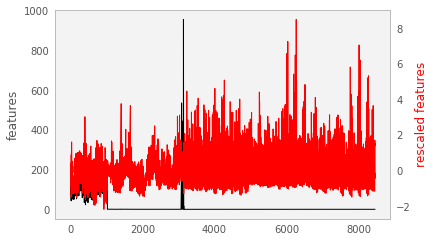

In [157]:
feat = detector.featurize(imageWindows[0]).reshape((1, -1))
rescaled = detector.scaler.transform(feat)
fig, ax = plt.subplots()
ax.plot(feat.ravel(), linewidth=1, color='black')
ax.set_ylabel('features')
# ax.set_yscale('log')

ax2 = ax.twinx()
ax2.plot(rescaled.ravel(), linewidth=1, color='red');
ax2.set_ylabel('rescaled features', color='red')

ax.grid(False)
ax2.grid(False)

# Demonstrate the detector; check accuracy.

HBox(children=(IntProgress(value=0, description='predict: ', max=6726), HTML(value='')))

/home/tsbertalan/.virtualenvs/carnd/lib/python3.5/site-packages/skimage/feature/_hog.py:119: skimage_deprecation: Default value of `block_norm`==`L1` is deprecated and will be changed to `L2-Hys` in v0.15
  'be changed to `L2-Hys` in v0.15', skimage_deprecation)


HBox(children=(IntProgress(value=0, description='feat. & transf.: ', max=6726), HTML(value='')))


The classifier rates its accuracy as 0.99955396967


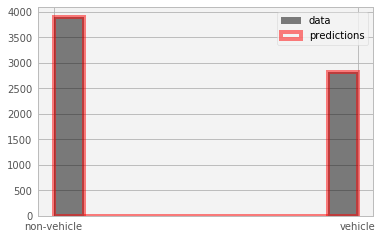

In [158]:
def predict(image):
    feat = detector.featurize(image).reshape((1, -1))
    rescaled = detector.scaler.transform(feat)
    return np.copy(detector.clf.predict(rescaled))

predictions = np.stack([
    predict(np.copy(image)) 
    for image in 
    tqdm.tqdm_notebook(images, desc='predict')
])

fig, ax = plt.subplots()
ax.hist([bool(y) for y in classes], color='black', label='data', alpha=.5);
ax.hist(predictions, edgecolor='red', linewidth=4, label='predictions', alpha=.5, facecolor='none')
ax.legend()
ax.set_xticks([0, 1])
ax.set_xticklabels(['non-vehicle', 'vehicle'])

print(
    'The classifier rates its accuracy as',
    detector.clf.score(
        np.vstack([
            detector.scaler.transform(detector.featurize(image).reshape((1, -1)))
            for image in 
            tqdm.tqdm_notebook(images, desc='feat. & transf.')
        ]),
        [bool(y) for y in classes]
    )
)

# Run the detector on a test image.

In [214]:
testImages = [
    vehicleDetection.data.readImage('test_images/test%d.jpg' % (k+1,))
    for k in range(6)
]

### Examine the distribution of train and test pixels.

In [189]:
def showPixeldist(imagelist, label, log=True):
    
    hsvStack = np.vstack([
        cv2.cvtColor(im, cv2.COLOR_RGB2HSV)
        for im in imagelist
    ])

    pixels = np.vstack([hsvStack[:, :, k].ravel() for k in range(3)]).T

    h = pixels[:, 0]
    s = pixels[:, 1]
    v = pixels[:, 2]
    
    if log:
        transform = lambda x: np.log1p(x) / np.log(10)
        label = '$\log_{10}($ bin counts $+1)$'
    else: 
        transform = lambda x: x
        label = 'bin counts'
    
    def largeScatter(x, y, ax):
        heatmap, xedges, yedges = np.histogram2d(x, y, bins=50)
        extent = [xedges[0], xedges[-1], yedges[0], yedges[-1]]
        im = ax.imshow(
            transform(heatmap.T), extent=extent, 
            origin='lower', aspect='auto', interpolation='spline16'
        )
        ax.grid(False)
        return im

    fig, (ax1, ax2) = plt.subplots(ncols=2, figsize=(16, 6))
    largeScatter(h, s, ax1)
    ax1.set_xlabel('H channel')
    ax1.set_ylabel('S channel')

    fig.colorbar(largeScatter(h, v, ax2), label=label)
    ax2.set_xlabel('H channel')
    ax2.set_ylabel('V channel')

    fig.suptitle(label)
    return fig, (ax1, ax2)

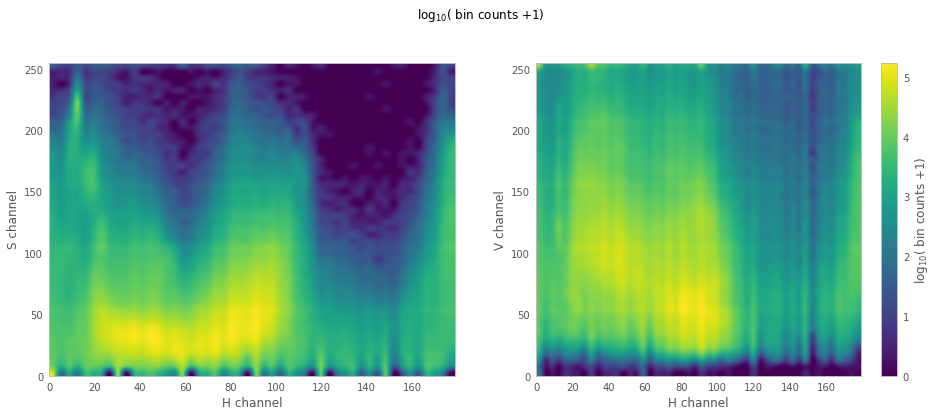

In [190]:
fig, axes = showPixeldist(images, 'all pixels in training data (%d images)' % len(images))
fig.savefig('doc/distTrain.png')

In [191]:
allTestWindows = []
for im in testImages:
    allTestWindows.extend(extractWindows(im))

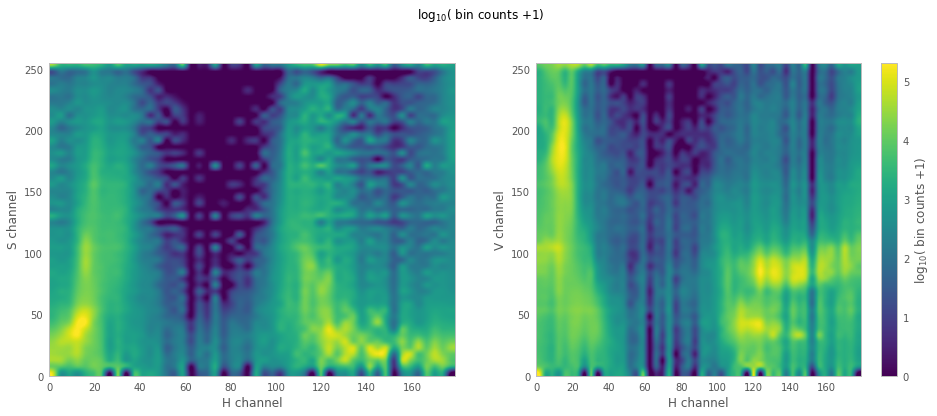

In [192]:
fig, axes = showPixeldist(allTestWindows, 'all pixels in test data (%d images)' % len(allTestWindows))
fig.savefig('doc/distTest.png')

Make a hue key.

(0.0, 179.0)


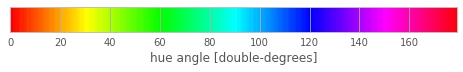

In [193]:
xl = axes[0].get_xlim()
# xl = 0, 512
print(xl)
ncol = 256
nrow = 10
h = np.linspace(*xl, ncol) * np.ones((nrow, 1))
s = np.ones_like(h) * 255
v = np.ones_like(h) * 255
hsv = np.dstack((h, s, v)).astype('uint8')
rgb = cv2.cvtColor(hsv, cv2.COLOR_HSV2RGB)
fig, ax = plt.subplots(figsize=(8, 2))
ax.imshow(rgb, extent=[xl[0], xl[1], 0, nrow], aspect='equal')
ax.set_yticks([]);
ax.set_xlabel('hue angle [double-degrees]')
fig.savefig('doc/hueAngle.png')

### Chose a test image.

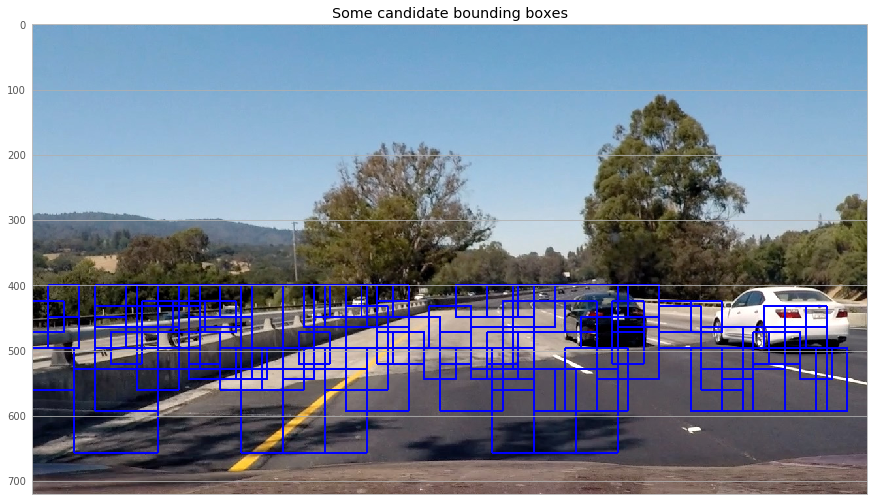

In [266]:
itest = 3
impath = 'test_images/test%d.jpg' % (itest + 1,)
img = testImages[itest]

windows = vehicleDetection.search.slide_window(img)

windows = [w for w in detector.generateWindows(img)]
np.random.shuffle(windows)

nwin = 96

fig, ax = plt.subplots(figsize=(16,9))
ax.imshow(
    vehicleDetection.drawing.draw_boxes(
        img, windows[:nwin], thick=2,
    )
)
ax.set_xticks([]);
# ax.set_yticks([]);
ax.set_title('Some candidate bounding boxes')

Examine the test windows used.

In [267]:
def extractWindows(img):
    return [
        cv2.resize(
            img[window[0][1]:window[1][1], window[0][0]:window[1][0]], 
            (64, 64)
        )
        for window in windows
    ]

In [268]:
testWindowImages = extractWindows(img)

In [269]:
for k in range(3):
    print(k, end=' ')
    print(min([image[:, :, k].min() for image in images]), end=' ')
    print(max([image[:, :, k].max() for image in images]))

0 0 255
1 0 255
2 0 255


What is the distribution of predictions on this test image?

In [270]:
predictions = np.stack([
    detector.clf.predict(
        detector.scaler.transform(
            detector.featurize(im).reshape((1, -1))
        )
    )
    for im in testWindowImages
])

/home/tsbertalan/.virtualenvs/carnd/lib/python3.5/site-packages/skimage/feature/_hog.py:119: skimage_deprecation: Default value of `block_norm`==`L1` is deprecated and will be changed to `L2-Hys` in v0.15
  'be changed to `L2-Hys` in v0.15', skimage_deprecation)


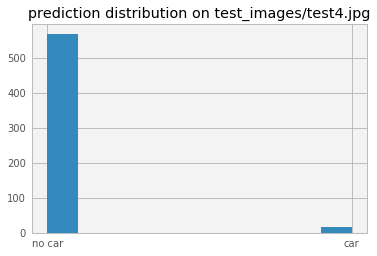

In [271]:
fig, ax = plt.subplots()
ax.hist(predictions)
ax.set_xticks([0, 1])
ax.set_xticklabels(['no car', 'car'])
ax.set_title('prediction distribution on %s' % impath);

Compare them to the training data.

/home/tsbertalan/.virtualenvs/carnd/lib/python3.5/site-packages/skimage/feature/_hog.py:119: skimage_deprecation: Default value of `block_norm`==`L1` is deprecated and will be changed to `L2-Hys` in v0.15
  'be changed to `L2-Hys` in v0.15', skimage_deprecation)


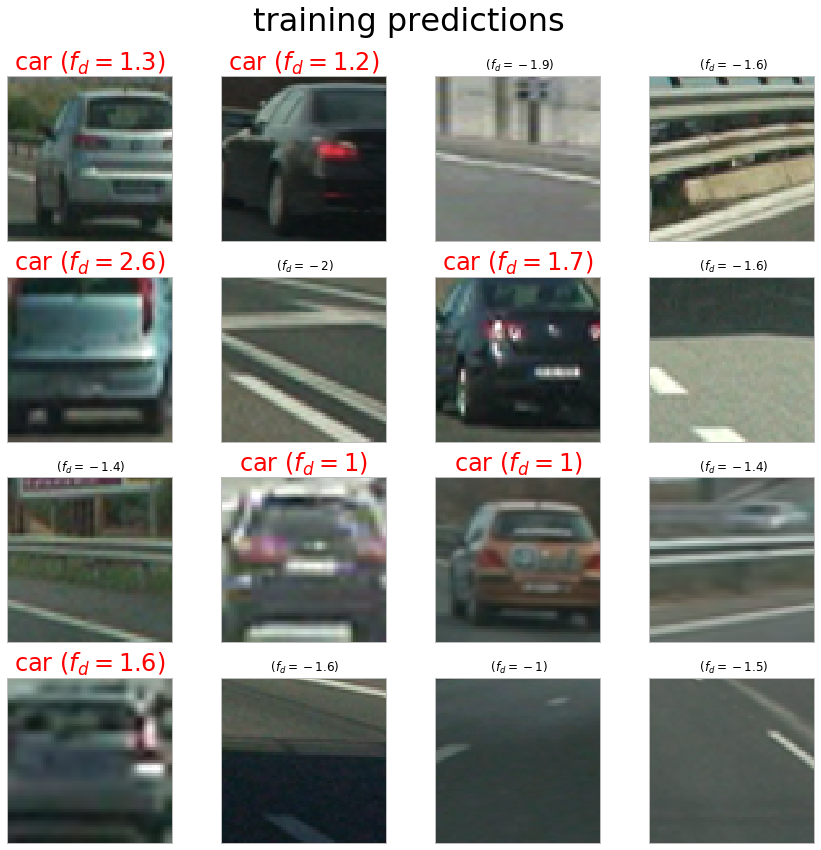

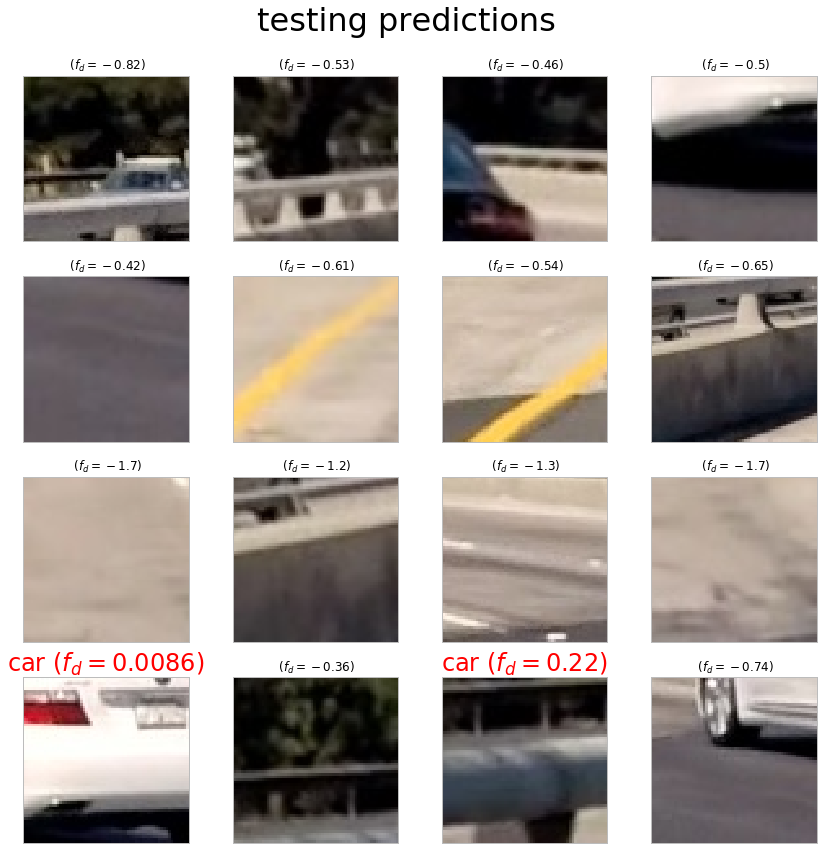

In [272]:
for imgs, suptitle in zip(
    [imageWindows, testWindowImages], 
    ['training predictions', 'testing predictions'],
):
    fig, axes = plt.subplots(nrows=4, ncols=4, figsize=(12, 12))
    axes = axes.ravel()
    for im, ax in zip(imgs, axes): 
#         if (np.abs(im) <= 1).all():
#             ax.imshow(np.clip(im*255, 0, 255).astype('uint8'))
# #             ax.imshow(im)
#         else:
        ax.imshow(im)
        features = detector.featurize(im).reshape((1, -1))
        test_features = detector.scaler.transform(features)
        pred = detector.clf.predict(test_features)
        if hasattr(detector.clf, 'decision_function'):
            decisionFunc = detector.clf.decision_function(test_features)
            dftext = ' ($f_d=%.2g$)' % decisionFunc
        else:
            dftext = ''
        ax.set_xticks([]); ax.set_yticks([])
        title = 'car%s' % dftext if pred else dftext
        ax.set_title(
            title, 
            color='red' if pred else 'black',
            fontsize=24 if pred else 12
        )
    fig.tight_layout()
    fig.suptitle(suptitle, fontsize=32)
    fig.subplots_adjust(top=.9)
    fig.savefig('doc/%s.png' % suptitle)

In [273]:
windows = detector.rawDetect(img)

/home/tsbertalan/.virtualenvs/carnd/lib/python3.5/site-packages/skimage/feature/_hog.py:119: skimage_deprecation: Default value of `block_norm`==`L1` is deprecated and will be changed to `L2-Hys` in v0.15
  'be changed to `L2-Hys` in v0.15', skimage_deprecation)


In [274]:
len(windows), len(detector.generateWindows(img))

(18, 587)

/home/tsbertalan/.virtualenvs/carnd/lib/python3.5/site-packages/skimage/feature/_hog.py:119: skimage_deprecation: Default value of `block_norm`==`L1` is deprecated and will be changed to `L2-Hys` in v0.15
  'be changed to `L2-Hys` in v0.15', skimage_deprecation)


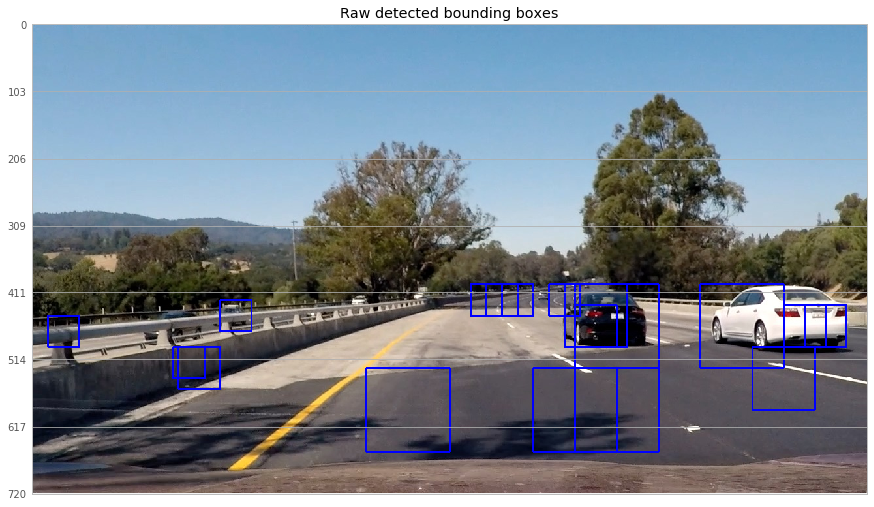

In [275]:
# from IPython.core.debugger import set_trace; set_trace()
ax = detector.drawDetect(img)
ax.set_title('Raw detected bounding boxes')
ax.set_yticks(np.round(np.linspace(0, 720, 8)));

/home/tsbertalan/.virtualenvs/carnd/lib/python3.5/site-packages/skimage/feature/_hog.py:119: skimage_deprecation: Default value of `block_norm`==`L1` is deprecated and will be changed to `L2-Hys` in v0.15
  'be changed to `L2-Hys` in v0.15', skimage_deprecation)


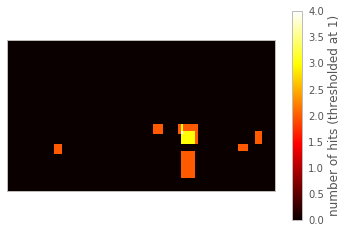

In [276]:
heatmap = detector.heat(img.shape, detector.rawDetect(img))
thr = 1
heatmap[heatmap <= thr] = 0
fig, ax = plt.subplots()
im = ax.imshow(heatmap[:, :, 0], cmap=mpl.cm.hot)
fig.colorbar(im, label='number of hits (thresholded at %d)' % thr)
ax.set_xticks([])
ax.set_yticks([]);

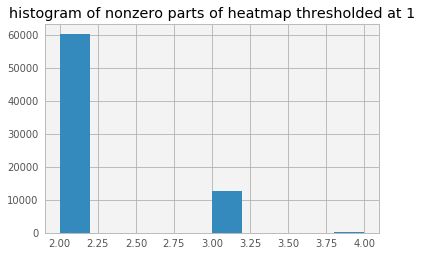

In [277]:
fig, ax = plt.subplots()
nz = heatmap[heatmap>0]
ax.hist(nz.ravel());
ax.set_title('histogram of nonzero parts of heatmap thresholded at %d' % thr);

/home/tsbertalan/.virtualenvs/carnd/lib/python3.5/site-packages/skimage/feature/_hog.py:119: skimage_deprecation: Default value of `block_norm`==`L1` is deprecated and will be changed to `L2-Hys` in v0.15
  'be changed to `L2-Hys` in v0.15', skimage_deprecation)


Found 6 labels.


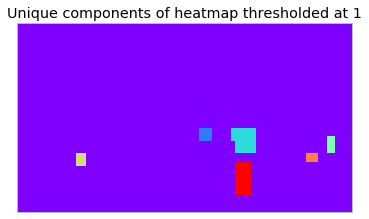

In [278]:
labels = detector.detect(img, threshold=thr)[0][:, :, 0]
fig, ax = plt.subplots()
ax.imshow(labels, cmap=mpl.cm.rainbow)
ax.set_xticks([])
ax.set_yticks([]);
ax.set_title('Unique components of heatmap thresholded at %d' % thr);

/home/tsbertalan/.virtualenvs/carnd/lib/python3.5/site-packages/skimage/feature/_hog.py:119: skimage_deprecation: Default value of `block_norm`==`L1` is deprecated and will be changed to `L2-Hys` in v0.15
  'be changed to `L2-Hys` in v0.15', skimage_deprecation)


Found 6 labels.


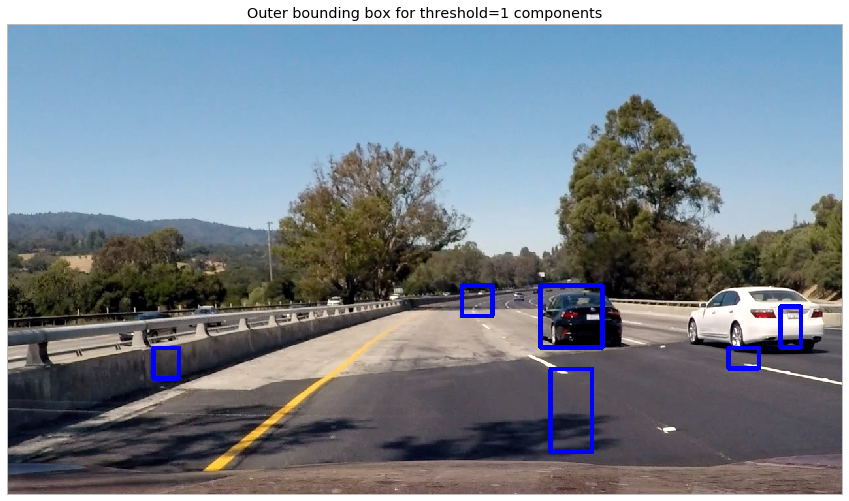

In [279]:
import os
ax = detector.drawHeat(img, threshold=thr)
ax.set_title('Outer bounding box for threshold=%d components' % thr)
outname = os.path.basename(impath).replace('.jpg', '-detections.jpg')
ax.figure.savefig('doc/%s' % outname)